# EDA on a Hugging Face dataset

Fine-tuning the best Large Language Models (LLMs) is not an option: they are proprietary, accessible only via apps and APIs. Fine-tuning an open-source LLM is possible but not always practical or appealing. Thus, In-Context Learning (ICL) is a popular alternative, for those with the right custom data.

Background: In-Context Learning (few-shot learning) involves augmentation at inference. The sequence ingested by the model is the unlabeled input concatenated with context (labeled examples) that primes the model toward desired output, albeit indirectly. In 2023, ICL is a hot topic.

Challenge: Methods abound for selecting contextual exemplars per input, and the performance benefits of ICL vary dramatically across selection methods. New learning-based approaches show promise ([Ye et al.](https://arxiv.org/abs/2302.05698), [Xu et al.](https://arxiv.org/abs/2305.08848)), but require more labeled examples than do learning-free approaches. Other factors that moderate the influence of contextual subsets include relevance and diversity.

Dataset: In 2015, [Zhang et al.](https://arxiv.org/abs/1509.01626) compiled several datasets, including one sourced from Yahoo that is available via Hugging Face. It includes 1.46 million question-answer pairs, labeled according to topic. The content comes from Yahoo Answers, a crowdsourced QA site deprecated in 2021 (content is from pre-2007).

Goal: The present EDA will shed light on the suitability of this dataset for learning-based ICL methods, especially SuperICL and CEIL, in support of LLM-based generative QA as well as text classification.

In [1]:
import matplotlib.pyplot as plt
from eda_funcs import *

pd.set_option('max_colwidth', 200)

## Check size

In [2]:
builder = datasets.load_dataset_builder('yahoo_answers_topics')
show_size(builder)

,size in MB,number of examples
train,725,1400000
test,31,60000


## Download, preview sample

In [3]:
ds = load_yahoo(split='train', num_shards=32, shard_index=0)
print(f"number of rows: {ds.num_rows}\n")
ds[:5]

Found cached dataset yahoo_answers_topics (/home/mark/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439)
Loading cached processed dataset at /home/mark/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439/cache-af313abec8be221e.arrow


number of rows: 43750



,id,label,question,answer,topic
0,0,4,why doesn't an optical mouse work on a glass table?,Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse. The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect ...,Computers & Internet
1,32,5,Formula1 car,"Let me break it down-\nEngine- 3 liter V10. Approximately 900+ hp, 19,000 rpm. The engine weighs about 200 lbs. It spins so fast that metal valve springs can't keep, the springs are pneumatic.\...",Sports
2,64,0,Can anyone list the short name of the common names?,"Al - Albert, Alfred, Alan<br />\nBob - Robert <br />\nBeth - Elizabeth <br />\nBill(y) - William <br />\nCathy - Catherine <br />\nChris - Christopher<br />\nDeb(bie) - Deborah, Debra <br />\nDick...",Society & Culture
3,96,7,Who is Earth-2 Superman and how is he different from regular Superman?,"It's relatively simple. Back in 1961, DC Comics revealed that all of their Golden Age (c. 1939-1945) characters had lived on a different Earth from their Silver Age (c. 1956-1970) characters. So...",Entertainment & Music
4,128,1,Why do we get tickled when somebody tickles us and we don't when we tickle ourselves?,"When we tickle ourselves, our mind knows in advance that is supposed to happen. So we develop some sort of a defence to counter the effect of the tickle.\nWhen somebody else tickles us suddenly ou...",Science & Mathematics


In [4]:
ds.cleanup_cache_files()

1

### Check topic balance

In [5]:
ds[:].value_counts(['label', 'topic']).to_frame().sort_index()

,,count
label,topic,
0,Society & Culture,4475
1,Science & Mathematics,4187
2,Health,4404
3,Education & Reference,4363
4,Computers & Internet,4460
5,Sports,4393
6,Business & Finance,4359
7,Entertainment & Music,4339
8,Family & Relationships,4456


### Check missing values

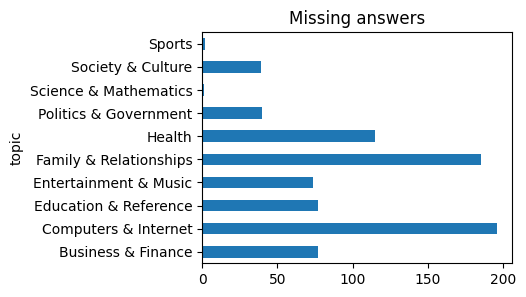

In [6]:
ds[:].query("answer == ''").groupby(['topic'])['id'].count().plot(
    kind='barh', figsize=(4,3), title='Missing answers')
plt.show()

### Inspect concise questions

In [7]:
mono_q = ds.filter(lambda x: len(x['question'].split())==1)[:10]['question']
duo_q = ds.filter(lambda x: len(x['question'].split())==2)[:10]['question']

pd.DataFrame({'1-word Questions': mono_q, 
              '2-word Questions': duo_q})

Filter:   0%|          | 0/43750 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43750 [00:00<?, ? examples/s]

,1-word Questions,2-word Questions
0,?????????????????,Formula1 car
1,Probibility?,what's environment?
2,hunting............................?,Oracle Financials?
3,motalebimran@yahoo.com?,Doggie DNA?
4,tannign......?,War yes/no?
5,how/to/talk/with/girls/to/attract/them?,Kissing tips?
6,tetraplegia?,its riddle.?
7,Supernatural?,Phone System?
8,Help!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?,Trig Function?
9,Supplements?,again riddle?


### Drop rows with blank answers, blank questions, or 1-word questions; Review topic balance

Filter:   0%|          | 0/43750 [00:00<?, ? examples/s]

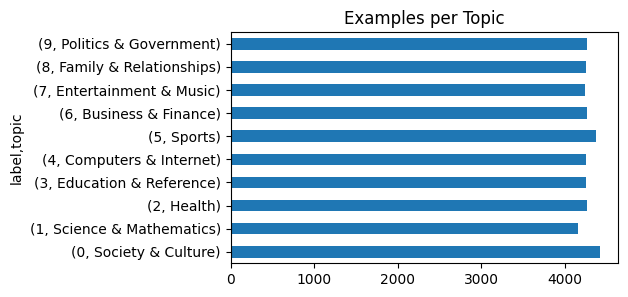

In [8]:
ds = ds.filter(lambda x: x['answer'] != '' and x['question'] != '' and len(x['question'].split()) > 1)
df = ds[:].value_counts(['label', 'topic']).to_frame().sort_index()
df.plot(kind='barh', figsize=(5, 3), title='Examples per Topic', legend=False)
plt.show()

### Preliminary observations

- This shard of the training dataset is large and balanced. For comparison, Rubin et al. use 44k examples to train a receiver for ICL. This Yahoo Answers dataset from huggingface is 32x that size.
- As stated [elsewhere](https://en.wikipedia.org/wiki/Yahoo!_Answers), at least some examples appear silly, inarticulate, or worse.

___

## Check question quality

### How do questions begin?

Map:   0%|          | 0/42747 [00:00<?, ? examples/s]

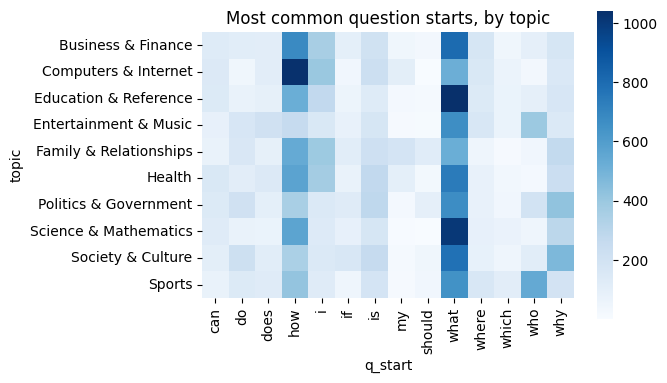

In [9]:
ds.reset_format()
ds = ds.map(q_start)
ds.set_format('pandas')
plot_question_starters(ds)

In [10]:
ds[:].query("q_start == 'i'")[:3]

,id,label,question,answer,topic,q_start
23,736,3,I want to learning about Japanese grammar. So anyone help me?,"Find you a copy of ""Genki - An integrated course in Elementary Japanese"" published by The Japan Times. It's the best introduction to the language that I've found. You may be able to find one at ...",Education & Reference,i
46,1472,2,I need an energy boost...natural ingredients preferred...home remedies welcome?,Make sure to always eat breakfast. I think instant oatmeal or yogurt is best. Take a Ginseng and Fish Oil Supplement. Do some breathing exercises before lunch. Breathe in through you nose and ...,Health,i
47,1504,6,I worry too much about what others think of the questions I ask. Should I?,Just ask what you want. If you think that other people are going to theink it's a stupid question then forget them. If you have actually bothered to look at the questions that some people have ask...,Business & Finance,i


In [11]:
ds = ds.remove_columns(['q_start'])

### Observations

- *What?* is common.
- *Who?* is especially common in Sports, Entertainment & Music.
- *Why?* is especially common in Politics & Gov't, Society & Culture.
- *How?* is especially common in Computers & Internet.
- *I* is unexpectedly common across all topics, framing questions with first-person narrative.

Questions that start with *I* are indirect and long, requiring sythesis across sentences and interpretation. These are not the best candidates for ICL.

___

## Word counts

In [12]:
ds = word_counts(ds)
ds[:][['q_word_count', 'ans_word_count']].describe().astype(int)

Map:   0%|          | 0/42747 [00:00<?, ? examples/s]

Map:   0%|          | 0/42747 [00:00<?, ? examples/s]

Map:   0%|          | 0/42747 [00:00<?, ? examples/s]

Map:   0%|          | 0/42747 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42747 [00:00<?, ? examples/s]

,q_word_count,ans_word_count
count,42631,42631
mean,10,63
std,5,91
min,1,1
25%,7,14
50%,10,34
75%,14,75
max,30,824


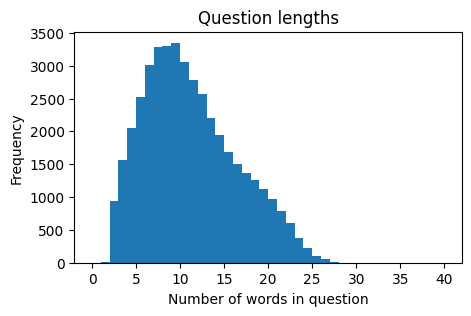

In [13]:
ds.set_format('pandas')
plt.figure(figsize=(5, 3))
plt.title('Question lengths')
plt.xlabel('Number of words in question')
plt.ylabel('Frequency')
plt.hist(ds['q_word_count'], bins=40, range=(0, 40), histtype='bar', rwidth=2)
plt.show()

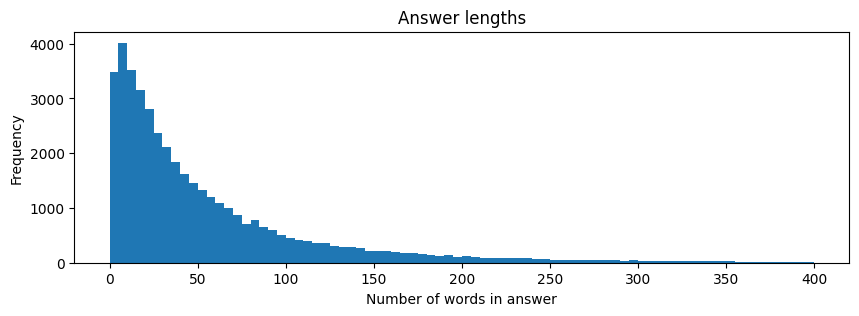

In [14]:
plt.figure(figsize=(10, 3))
plt.title('Answer lengths')
plt.xlabel('Number of words in answer')
plt.ylabel('Frequency')
plt.hist(ds[:]['ans_word_count'], bins=80, range=(0,400), histtype='bar', rwidth=2)
plt.show()


In [15]:
ds = ds.remove_columns(['q_word_count', 'ans_word_count'])

### Observations

- RoBERTa has max sequence length of 512 tokens. The majority of these examples would fit.
- The proprietary LLMs have context length ranging up to 4096. Multiple of these examples could fit within a single context.

___

## Conclusions

EDA does not determine how a dataset for learning-based ICL would influence a model's output. Even indicators of similarity (between an unlabeled input and a labeled contextual exemplar) and diversity (within the concatenated exemplar set per input) do not determine precisely how well a dataset will work for ICL: the best trade-off between relevance and diversity differs across tasks. The same goes for the number of in-context examples per input. EDA is only a start.

Nonetheless, we can draw a few conclusions.
- The size and breadth of the Yahoo Answers dataset is its strength, especially for learning-based ICL methods.
- The sequence length of tokenized question-answer pairs in this dataset is an appropriate length for the in-context learning methods discussed at the outset, namely CEIL (optimizing the context retriever's subset selection) and SuperICL (fine-tuning RoBERTa in a cascade design).

[Rubin et al.](https://aclanthology.org/2022.naacl-main.191/) argue that the best context for ICL is generated by a scoring LLM, separate from the inference LLM. That may be the case. For crowdsourced data, Yahoo Answers provides a large, diverse set.

Personally, I would not twist anyone's arm to use this dataset.
- It is difficult to fact check.
- Other datasets exist -- synthetic or real.
- Starting with a small, high-quality dataset seems more reasonable than harvesting a huge, dubious one.
- Yahoo shut down the site. Of course, that was in 2021. Still, the decision raises questions.